# 08. PyTorch Experiment Tracking Exercises

Welcome to the 08. PyTorch Paper Replicating exercises.

Your objective is to write code to satisify each of the exercises below.

Some starter code has been provided to make sure you have all the resources you need.

> **Note:** There may be more than one solution to each of the exercises.

## Resources

1. These exercises/solutions are based on [section 08. PyTorch Paper Replicating](https://www.learnpytorch.io/08_pytorch_paper_replicating/) of the Learn PyTorch for Deep Learning course by Zero to Mastery.
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/tjpW_BY8y3g) (but try the exercises yourself first!).
3. See [all solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

> **Note:** The first section of this notebook is dedicated to getting various helper functions and datasets used for the exercises. The exercises start at the heading "Exercise 1: ...".

### Get various imports and helper functions

The code in the following cells prepares imports and data for the exercises below. They are taken from [08. PyTorch Paper Replicating](https://www.learnpytorch.io/08_pytorch_paper_replicating/).

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")


[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/nightly/cu113
torch version: 2.1.0+cu118
torchvision version: 0.16.0+cu118


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4036, done.
remote: Counting objects: 100% (1224/1224), done.
remote: Compressing objects: 100% (227/227), done.
remote: Total 4036 (delta 1064), reused 1100 (delta 994), pack-reused 2812
Receiving objects: 100% (4036/4036), 651.60 MiB | 26.28 MiB/s, done.
Resolving deltas: 100% (2357/2357), done.
Updating files: 100% (248/248), done.


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Get data

Want to download the data we've been using in PyTorch Paper Replicating: https://www.learnpytorch.io/08_pytorch_paper_replicating/#1-get-data

In [4]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [5]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

### Preprocess data

Turn images into tensors using same code as PyTorch Paper Replicating section 2.1 and 2.2: https://www.learnpytorch.io/08_pytorch_paper_replicating/#21-prepare-transforms-for-images

In [6]:
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [7]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7cc08c14e050>,
 ['pizza', 'steak', 'sushi'])

In [8]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

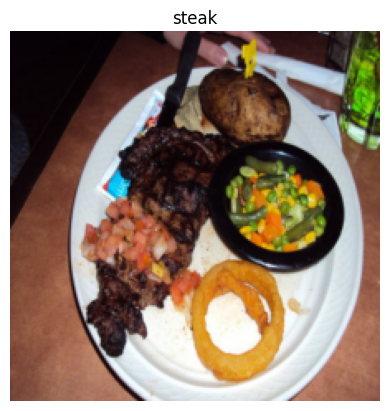

In [9]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

## 1. Replicate the ViT architecture we created with in-built [PyTorch transformer layers](https://pytorch.org/docs/stable/nn.html#transformer-layers).

* You'll want to look into replacing our `TransformerEncoderBlock()` class with [`torch.nn.TransformerEncoderLayer()`](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html#torch.nn.TransformerEncoderLayer) (these contain the same layers as our custom blocks).
* You can stack `torch.nn.TransformerEncoderLayer()`'s on top of each other with [`torch.nn.TransformerEncoder()`](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html#torch.nn.TransformerEncoder).

Para o patch embedding inicial, eu preciso de:
  * patch_size
  * N_channels

O embedding inicial transforma a imagem em patches de patch_size X patch_size. Isso totaliza k = (img_width / patch_size) X (img_height / patch_size) patches. Cada patch de shape (patch_size X patch_size X N_channels) terá esse valor de dimensionalidade de embedding depois de realizar o flatten.

Para realizar esse embedding, podemos usar uma convolução 2d do Pytorch com kernel_size e stride igual a patch_size. Acredito que esse seja o modelo híbrido mencionado no paper. Se não, teríamos que fazer na mão a divisão da imagem em patches. Uma vez com a convolução feita, temos que realizar o flatten de cada patch embedding.

In [10]:
# TODO: your code
class PatchEmbedding(nn.Module):
  """
  Aplica uma convolução e depois um flatten
  Precisa de imagens no formato (N, C, H, W)
  N = batch size
  C = channels
  H = height
  W = width

  Retorna embeddings de shape (N, (H/patch_size) * (W/patch_size), n_dims)
  O n_dims deve ser igual a C*patch_size*patch_size

  Exemplo:
  imgs shape: (32, 3, 224, 224)
  patch_size = 16, n_channels=3, n_dims=768
  Retorna: (32, (224/16)*(224/16)=196, 3*16*16=768)
  """
  def __init__(self, patch_size:int=16, n_channels:int=3, n_dims:int=768):
    super().__init__()

    self.patch_size = patch_size
    self.patcher = nn.Conv2d(in_channels=n_channels,
                             out_channels=n_dims,
                             kernel_size=patch_size,
                             stride=patch_size, padding=0
                             ) # (C_{out}, H_{out}, W_{out}) -> (n_dims, n_patches_H, n_patches_W)

    self.flatten = nn.Flatten(start_dim=2, end_dim=3) # (n_dims, n_patches X n_patches)

  def forward(self, x):
    assert x.shape[-1] % self.patch_size == 0, f"Dimensões da imagem devem ser divisíveis pelo patch_size {self.patch_size}"

    return self.flatten(self.patcher(x)).permute(0, 2, 1)

In [11]:
rand_img = torch.randn((1, 3, 224, 224))
patcher = PatchEmbedding()
patcher(rand_img).shape

torch.Size([1, 196, 768])

Seguindo o exemplo da documentação da classe acima, teremos 196 patches com 768 dimensões por imagem.

Uma vez com os patch embeddings, devemos adicionar um token de classe aprendível como se fosse um novo patch. Dessa forma, se o patch embedding resultante tiver shape de (32, 196, 768), adicionando mais um patch com 768 dimensões, teremos (32, 197, 768).

Além disso, também devemos adicionar valores aprendíveis como positional embeddings a todo valor de toda imagem. Dessa forma, temos que criar outro tensor de shape (32, 197, 768) com requires_grad = True, para ser aprendido ao longo do treinamento e somá-lo ao embedding.

In [12]:
class PreEmbedder(nn.Module):
  """
  Realiza o PatchEmbedding. Depois, concatena mais um patch de n_dims
  com o tensor de classe. Depois, soma o positional embedding aprendível
  ao embedding final.
  A dimensionalidade do embedding por patch será igual a
  n_channels*(patch_size**2).
  O número total de patches será (img_shape[0]/patch_size) * (img_shape[1]/patch_size)

  Retorna um tensor de shape: (batch_size, n_patches+1, n_dims)
  """
  def __init__(self, patch_size:int=16, n_channels:int=3,
               batch_size:int=1, img_shape:tuple=(224, 224)):
    super().__init__()
    n_dims = n_channels*(patch_size**2)
    self.patch_embedder = PatchEmbedding(patch_size, n_channels, n_dims)

    n_patches = int((img_shape[0]/patch_size) * (img_shape[1]/patch_size))
    self.class_token = nn.Parameter(
        torch.randn((batch_size, 1, n_dims)),
                                        requires_grad = True)
    self.pos_embeddings = nn.Parameter(
        torch.randn((batch_size, n_patches+1, n_dims)),
    requires_grad=True)

  def forward(self, x):
    x = self.patch_embedder(x)
    x = torch.concat((self.class_token, x), dim=1)
    return x+self.pos_embeddings


In [13]:
rand_img = torch.randn((1, 3, 224, 224))
embedder = PreEmbedder()
embedder(rand_img).shape

torch.Size([1, 197, 768])

Agora com a parte do embedding inicial pronta, passo às camadas de TransformerEncoder. Vou precisar de:
* N_dims: A dimensionalidade de embedding a ser mantida
* N_heads: O quantidade de heads do Multihead self-attention
* MLP_size: A quantidade de neurônios na camada oculta
O Pytorch possui uma classe que já monta um TransformerEncoder de nome TransformerEncoderLayer.

Temos que realizar o stack de j camadas de TransformerEncoder. Para tal, podemos usar uma classe do PyTorch chamada TransformerEncoder.


In [14]:
class TransformerEncoderStack(nn.Module):
  def __init__(self, n_dims:int=768, nhead:int=12, mlp_dim:int=3072,
               dropout:int=0.1, n_layers:int=12):
    super().__init__()
    # Uma camada das várias a serem stackadas
    self.transformer_encoder_layer = nn.TransformerEncoderLayer(
        d_model=n_dims,
        nhead=nhead,
        dim_feedforward=mlp_dim,
        dropout=dropout,
        activation="gelu", # De acordo com o paper
        batch_first=True, # De acordo com o paper
        norm_first=True, # De acordo com o paper
    )
    self.transformer_encoder_stack = nn.TransformerEncoder(self.transformer_encoder_layer,
                                                           num_layers=n_layers,
                                                           enable_nested_tensor=False # Para remover um warning
                                                           )

  def forward(self, x):
    return self.transformer_encoder_stack(x)

In [15]:
rand_img = torch.randn((1, 197, 768))
encoder_stack = TransformerEncoderStack()
encoder_stack(rand_img).shape

torch.Size([1, 197, 768])

Depois de aplicar as várias camadas de encoder, devemos realizar a classificação usando um MLP. Antes desse MLP, no entanto, devemos aplicar uma camada de normalização.

Devemos lembrar que passamos somente o primeiro encoded embedding resultante das várias camadas de TransformerEncoder para o MLP final como diz o paper. Ele é relativo ao embedding da classe adicionada no início como um novo patch.




In [16]:
class ClassificationHead(nn.Module):
  def __init__(self, in_feats:int=768, out_feats:int=3):
    super().__init__()
    self.classifier = nn.Sequential(
        nn.LayerNorm(normalized_shape=in_feats),
        nn.Linear(in_features=in_feats,
                  out_features=out_feats)
    )

  def forward(self, x):
    return self.classifier(x)

In [17]:
rand_img = torch.randn((1, 1, 768))
classifier = ClassificationHead()
classifier(rand_img)

tensor([[[-0.4700, -0.3190,  0.4364]]], grad_fn=<ViewBackward0>)

Agora, devemos juntar tudo em uma classe ViT só

In [18]:
class ViT(nn.Module):
  def __init__(self, patch_size:int=16, n_channels:int=3,
               batch_size:int=1, img_shape:tuple=(224, 224),
               nhead:int=12, mlp_dim:int=3072,
               dropout:int=0.1, n_layers:int=12,
               out_feats:int=3):
    super().__init__()
    self.embedder = PreEmbedder(patch_size, n_channels,
               batch_size, img_shape)

    n_dims = n_channels*(patch_size**2)
    self.encoder_stack = TransformerEncoderStack(n_dims, nhead, mlp_dim,
               dropout, n_layers)

    self.classifier = ClassificationHead(n_dims, out_feats)

  def forward(self, x):
    return self.classifier(self.encoder_stack(self.embedder(x))[:, 0])

In [19]:
rand_img = torch.randn((1, 3, 224, 224))
vit = ViT(batch_size=rand_img.shape[0])
vit(rand_img)

tensor([[ 0.5078,  0.5258, -0.6221]], grad_fn=<AddmmBackward0>)

In [20]:
vit

ViT(
  (embedder): PreEmbedder(
    (patch_embedder): PatchEmbedding(
      (patcher): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (flatten): Flatten(start_dim=2, end_dim=3)
    )
  )
  (encoder_stack): TransformerEncoderStack(
    (transformer_encoder_layer): TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
      )
      (linear1): Linear(in_features=768, out_features=3072, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=3072, out_features=768, bias=True)
      (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
    (transformer_encoder_stack): TransformerEncoder(
      (layers): ModuleList(
        (0-11): 12 x TransformerEncoderLaye

## 2. Turn the custom ViT architecture we created into a Python script, for example, `vit.py`.

* You should be able to import an entire ViT model using something like`from vit import ViT`.
* We covered the art of turning code cells into Python scrips in [05. PyTorch Going Modular](https://www.learnpytorch.io/05_pytorch_going_modular/).


Vou copiar todas as classes acima e suas bibliotecas necessárias para a célula abaixo e a transformar em um código Python importável

In [21]:
%%writefile vit.py
import torch
from torch import nn

class PatchEmbedding(nn.Module):
  """
  Aplica uma convolução e depois um flatten
  Precisa de imagens no formato (N, C, H, W)
  N = batch size
  C = channels
  H = height
  W = width

  Retorna embeddings de shape (N, (H/patch_size) * (W/patch_size), n_dims)
  O n_dims deve ser igual a C*patch_size*patch_size

  Exemplo:
  imgs shape: (32, 3, 224, 224)
  patch_size = 16, n_channels=3, n_dims=768
  Retorna: (32, (224/16)*(224/16)=196, 3*16*16=768)
  """
  def __init__(self, patch_size:int=16, n_channels:int=3, n_dims:int=768):
    super().__init__()

    self.patch_size = patch_size
    self.patcher = nn.Conv2d(in_channels=n_channels,
                             out_channels=n_dims,
                             kernel_size=patch_size,
                             stride=patch_size, padding=0
                             ) # (C_{out}, H_{out}, W_{out}) -> (n_dims, n_patches_H, n_patches_W)

    self.flatten = nn.Flatten(start_dim=2, end_dim=3) # (n_dims, n_patches X n_patches)

  def forward(self, x):
    assert x.shape[-1] % self.patch_size == 0, f"Dimensões da imagem devem ser divisíveis pelo patch_size {self.patch_size}"

    return self.flatten(self.patcher(x)).permute(0, 2, 1)

class PreEmbedder(nn.Module):
  """
  Realiza o PatchEmbedding. Depois, concatena mais um patch de n_dims
  com o tensor de classe. Depois, soma o positional embedding aprendível
  ao embedding final.
  A dimensionalidade do embedding por patch será igual a
  n_channels*(patch_size**2).
  O número total de patches será (img_shape[0]/patch_size) * (img_shape[1]/patch_size)

  Retorna um tensor de shape: (batch_size, n_patches+1, n_dims)
  """
  def __init__(self, patch_size:int=16, n_channels:int=3,
               batch_size:int=1, img_shape:tuple=(224, 224)):
    super().__init__()
    n_dims = n_channels*(patch_size**2)
    self.patch_embedder = PatchEmbedding(patch_size, n_channels, n_dims)

    n_patches = int((img_shape[0]/patch_size) * (img_shape[1]/patch_size))
    self.class_token = nn.Parameter(
        torch.randn((batch_size, 1, n_dims)),
                                        requires_grad = True)
    self.pos_embeddings = nn.Parameter(
        torch.randn((batch_size, n_patches+1, n_dims)),
    requires_grad=True)

  def forward(self, x):
    x = self.patch_embedder(x)
    x = torch.concat((self.class_token, x), dim=1)
    return x+self.pos_embeddings

class TransformerEncoderStack(nn.Module):
  def __init__(self, n_dims:int=768, nhead:int=12, mlp_dim:int=3072,
               dropout:int=0.1, n_layers:int=12):
    super().__init__()
    # Uma camada das várias a serem stackadas
    self.transformer_encoder_layer = nn.TransformerEncoderLayer(
        d_model=n_dims,
        nhead=nhead,
        dim_feedforward=mlp_dim,
        dropout=dropout,
        activation="gelu", # De acordo com o paper
        batch_first=True, # De acordo com o paper
        norm_first=True, # De acordo com o paper
    )
    self.transformer_encoder_stack = nn.TransformerEncoder(self.transformer_encoder_layer,
                                                           num_layers=n_layers,
                                                           enable_nested_tensor=False # Para remover um warning
                                                           )

  def forward(self, x):
    return self.transformer_encoder_stack(x)

class ClassificationHead(nn.Module):
  def __init__(self, in_feats:int=768, out_feats:int=3):
    super().__init__()
    self.classifier = nn.Sequential(
        nn.LayerNorm(normalized_shape=in_feats),
        nn.Linear(in_features=in_feats,
                  out_features=out_feats)
    )

  def forward(self, x):
    return self.classifier(x)

class ViT(nn.Module):
  def __init__(self, patch_size:int=16, n_channels:int=3,
               batch_size:int=1, img_shape:tuple=(224, 224),
               nhead:int=12, mlp_dim:int=3072,
               dropout:int=0.1, n_layers:int=12,
               out_feats:int=3):
    super().__init__()
    self.embedder = PreEmbedder(patch_size, n_channels,
               batch_size, img_shape)

    n_dims = n_channels*(patch_size**2)
    self.encoder_stack = TransformerEncoderStack(n_dims, nhead, mlp_dim,
               dropout, n_layers)

    self.classifier = ClassificationHead(n_dims, out_feats)

  def forward(self, x):
    return self.classifier(self.encoder_stack(self.embedder(x))[:, 0])

Writing vit.py


## 3. Train a pretrained ViT feature extractor model (like the one we made in [08. PyTorch Paper Replicating section 10](https://www.learnpytorch.io/08_pytorch_paper_replicating/#10-bring-in-pretrained-vit-from-torchvisionmodels-on-same-dataset)) on 20% of the pizza, steak and sushi data like the dataset we used in [07. PyTorch Experiment Tracking section 7.3](https://www.learnpytorch.io/07_pytorch_experiment_tracking/#73-download-different-datasets)
* See how it performs compared to the EffNetB2 model we compared it to in [08. PyTorch Paper Replicating section 10.6](https://www.learnpytorch.io/08_pytorch_paper_replicating/#106-save-feature-extractor-vit-model-and-check-file-size).

Fazendo o download dos dados

In [22]:
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


In [23]:
train_dir_20_percent = data_20_percent_path / "train"

print(f"Pasta de treinamento 20%: {train_dir_20_percent}")

Pasta de treinamento 20%: data/pizza_steak_sushi_20_percent/train


Conseguindo um modelo pré-treinado e o alterando para treinar nos nossos dados

In [24]:
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
pretrained_vit

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:05<00:00, 66.1MB/s]


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

Conseguindo os transforms do modelo

In [25]:
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


Criando os dataloaders

In [26]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=pretrained_vit_transforms,
    batch_size=32)

Treinando

In [27]:
from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7663 | train_acc: 0.7188 | test_loss: 0.5435 | test_acc: 0.8769
Epoch: 2 | train_loss: 0.3436 | train_acc: 0.9453 | test_loss: 0.3257 | test_acc: 0.8977
Epoch: 3 | train_loss: 0.2068 | train_acc: 0.9492 | test_loss: 0.2698 | test_acc: 0.9186
Epoch: 4 | train_loss: 0.1557 | train_acc: 0.9609 | test_loss: 0.2414 | test_acc: 0.9186
Epoch: 5 | train_loss: 0.1244 | train_acc: 0.9727 | test_loss: 0.2271 | test_acc: 0.8977
Epoch: 6 | train_loss: 0.1210 | train_acc: 0.9766 | test_loss: 0.2122 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.0933 | train_acc: 0.9766 | test_loss: 0.2342 | test_acc: 0.8883
Epoch: 8 | train_loss: 0.0793 | train_acc: 0.9844 | test_loss: 0.2268 | test_acc: 0.9081
Epoch: 9 | train_loss: 0.1084 | train_acc: 0.9883 | test_loss: 0.2064 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.0646 | train_acc: 0.9922 | test_loss: 0.1795 | test_acc: 0.9176


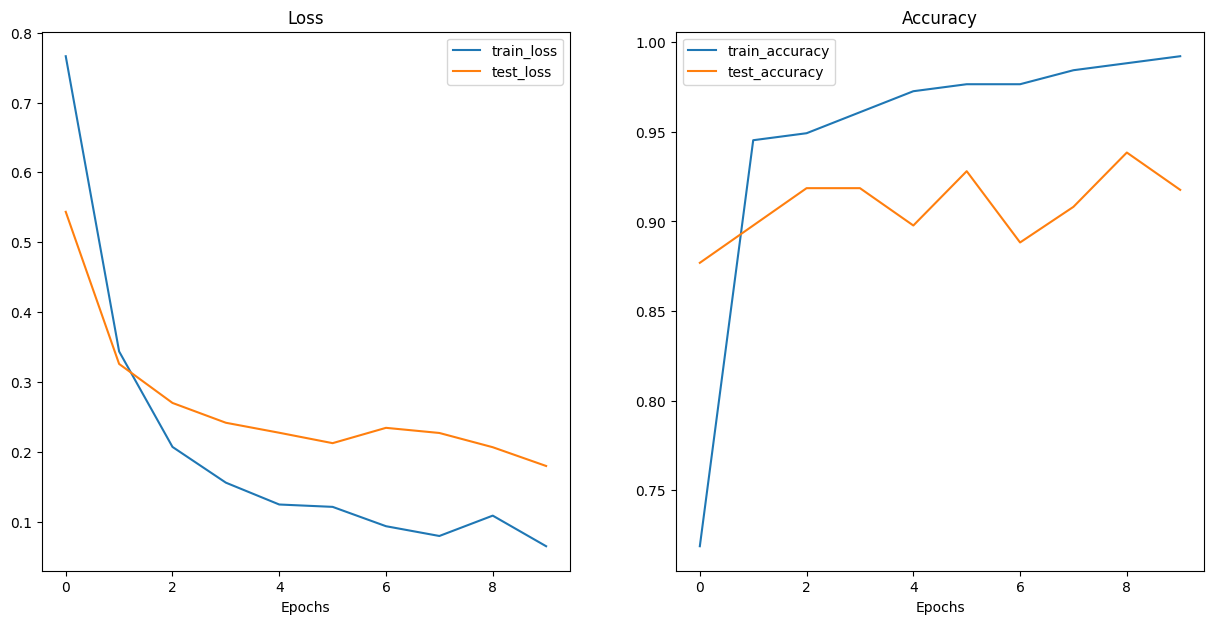

In [28]:
plot_loss_curves(pretrained_vit_results)

In [29]:
from going_modular.going_modular import utils
utils.save_model(model=pretrained_vit,
                 target_dir="models",
                 model_name="pretrained_vit_feature_extractor_pizza_steak_sushi.pth")

[INFO] Saving model to: models/pretrained_vit_feature_extractor_pizza_steak_sushi.pth


In [30]:
from pathlib import Path

pretrained_vit_model_size = Path("models/pretrained_vit_feature_extractor_pizza_steak_sushi.pth").stat().st_size // (1024*1024)
print(f"Pretrained ViT model size: {pretrained_vit_model_size} MB")

Pretrained ViT model size: 327 MB


Esse modelo, comparado com o EffNetB2 treinado na aula, atingiu menor loss e acurácia semelhante. Entretanto, ele possui 327MB de tamanho comparado com os 29MB do EffNetB2. Dessa forma, dependendo de qual o dispositivo que esse modelo estaria localizado, poderíamos ter que escolher o EffNetB2.

## 4. Try repeating the steps from excercise 3 but this time use the "`ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1`" pretrained weights from [`torchvision.models.vit_b_16()`](https://pytorch.org/vision/stable/models/generated/torchvision.models.vit_b_16.html#torchvision.models.vit_b_16).
* Note: ViT pretrained with SWAG weights has a minimum input image size of (384, 384), though this is accessible in the weights `.transforms()` method.

In [31]:
# TODO: your code
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1

pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
pretrained_vit

Downloading: "https://download.pytorch.org/models/vit_b_16_swag-9ac1b537.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16_swag-9ac1b537.pth
100%|██████████| 331M/331M [00:04<00:00, 81.9MB/s]


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [32]:
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[384]
    resize_size=[384]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


In [33]:
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=pretrained_vit_transforms,
    batch_size=32)

In [34]:
from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.4188 | train_acc: 0.8672 | test_loss: 0.1259 | test_acc: 0.9792
Epoch: 2 | train_loss: 0.0810 | train_acc: 0.9805 | test_loss: 0.0552 | test_acc: 0.9896
Epoch: 3 | train_loss: 0.0478 | train_acc: 0.9883 | test_loss: 0.0461 | test_acc: 0.9896
Epoch: 4 | train_loss: 0.0328 | train_acc: 0.9961 | test_loss: 0.0419 | test_acc: 0.9896
Epoch: 5 | train_loss: 0.0244 | train_acc: 0.9961 | test_loss: 0.0413 | test_acc: 0.9896
Epoch: 6 | train_loss: 0.0206 | train_acc: 0.9961 | test_loss: 0.0408 | test_acc: 0.9896
Epoch: 7 | train_loss: 0.0140 | train_acc: 0.9961 | test_loss: 0.0418 | test_acc: 0.9896
Epoch: 8 | train_loss: 0.0103 | train_acc: 1.0000 | test_loss: 0.0393 | test_acc: 0.9896
Epoch: 9 | train_loss: 0.0086 | train_acc: 1.0000 | test_loss: 0.0366 | test_acc: 0.9896
Epoch: 10 | train_loss: 0.0071 | train_acc: 1.0000 | test_loss: 0.0350 | test_acc: 0.9896


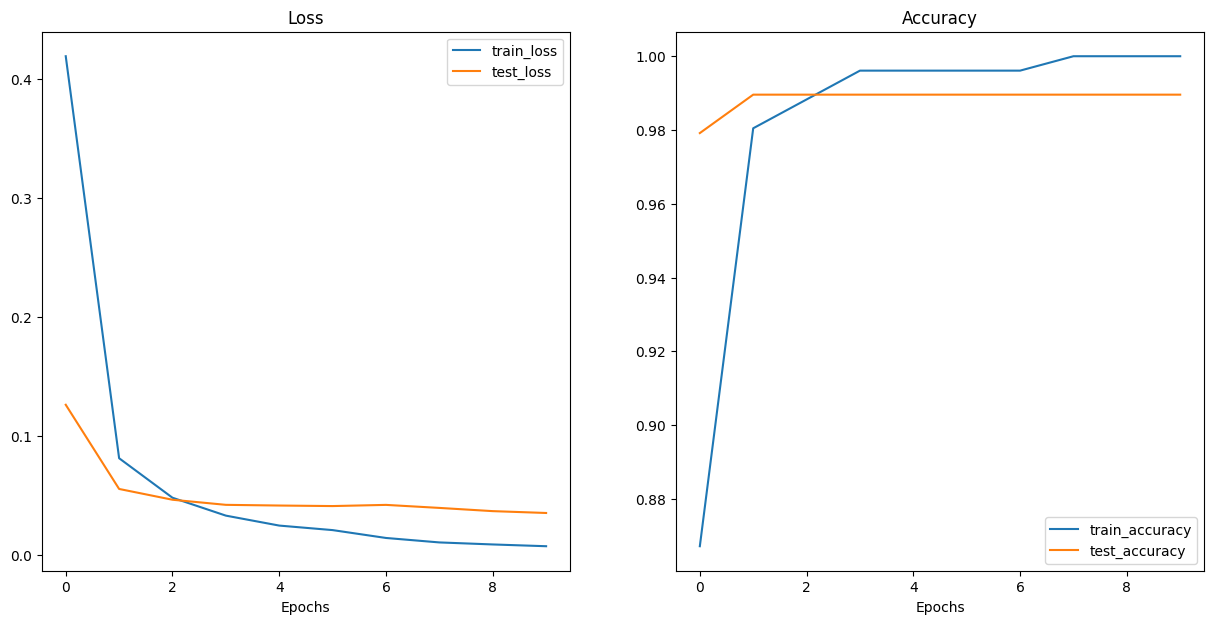

In [35]:
plot_loss_curves(pretrained_vit_results)

Esse modelo conseguiu performar melhor ainda com 0.98 de acurácia em teste e um loss muito baixo. Entretanto, ele não deixa de ser um modelo mais pesado do que o EffNetB2.

# 5. Our custom ViT model architecture closely mimics that of the ViT paper, however, our training recipe misses a few things.
* Research some of the following topics from Table 3 in the ViT paper that we miss and write a sentence about each and how it might help with training:
    * **ImageNet-21k pretraining**
    * **Learning rate warmup**
    * **Learning rate decay**
    * **Gradient clipping**

## ImageNet-21K pretraining

De acordo com o paper [ImageNet-21K Pretraining for the Masses](https://arxiv.org/abs/2104.10972), o dataset ImageNet-21K, também conhecido simplesmente como ImageNet, possui mais de 14 milhões de imagens divididas em quase 22 mil classes (por isso também pode ser chamado de ImageNet-22K). Esse dataset inteiro, pelo menos até a divulgação desse paper, não era o principal dataset utilizado para realizar o pré-treinamento de modelos voltados para imagens. O principal modelo era um subconjunto do ImageNet-21K chamado ImageNet-1K. Isso se deve ao fato de que o ImageNet, apesar de público, é muito grande com 1.3TB de dados e possui classes não mutualmente exclusivas. Por exemplo, dentro do dataset existem as classes "cadeira" e "móvel". A maioria das vezes, uma foto que contém uma cadeira será da classe "cadeira" mas, em outros casos, ela será da classe "móvel".

Esse paper apresenta um pré-processamento eficaz sobre o ImageNet-21K que permite modelos a melhorarem a sua performance em tarefas downstream. Provavelmente, isso deve ao fato de eles integrarem o uso da hierarquia existente entre as classes do dataset para realizar o treinamento em uma nova forma de avaliação que chamaram de *softmax semântico*.

## Learning rate warmup

De acordo com [essa pergunta no stackexchange](https://datascience.stackexchange.com/questions/55991/in-the-context-of-deep-learning-what-is-training-warmup-steps), [esse post no blog do baeldung](https://www.baeldung.com/cs/learning-rate-warm-up) e [essa pergunta no stackoverflow](https://stackoverflow.com/questions/55933867/what-does-learning-rate-warm-up-mean),  learning rate warmup é uma técnica de regularização utilizada para que os gradientes das primeiras iterações não levem o modelo em lugares longes do ótimo desnecessariamente. Dessa forma, precisamos de menos iterações para convergir.

Ele tem dois tipos principais:
- Linear: Usamos um learning rate menor fixo durante n épocas ou minibatches. Logo depois, passamos a usar o learning rate normal.
- Gradual: Começamos com um learning rate baixo que aumenta constantemente durante n épocas ou minibatches até alcançar o learning rate normal.

Uma vez que atingimos o learning rate normal, técnicas de learning rate decay ou scheduler podem ser aplicadas normalmente.

Um exemplo de motivo de uso de learning rate warmup é em uma validação cruzada randomizada. Pode ser que peguemos um primeiro batch com muitos elementos da mesma classe e, portanto, o modelo seria levado a parâmetros otimizados visando essa classe em detrimento de outras. Entretanto, usar o learning rate warmup diminui esse problema.

Parece ser um meta learning rate, já que o learning rate tem o objetivo de permitir o aprendizado em pequenos passos ajustáveis mas o warmup diminui o peso dos primeiros passos.

## Learning Rate decay

De acordo com o paper [How Does Learning Rate Decay Help Modern Neural Networks?](https://arxiv.org/abs/1908.01878), learning rate decay é uma técnica usada para treinar redes neurais modernas. Ela funciona por diminuir o  learning rate base ao longo das épocas. Existem vários jeitos de fazer isso. Podemos usar fórmulas estranhas ou o mais comum que é dividir o learning rate por uma constante a cada n épocas.

Esse mesmo paper discute os motivos acreditados de trazer os benefícios de usar learning rate decay até o momento mas propõe uma nova explicação. Um dos motivos acreditados para se usar o learning rate decay sob o ponto de vista do Gradient Descent, ou seja, não existem minibatches, é o de que com um learning rate suficientemente baixo, a rede irá convergir rápido mas, com um learning rate suficientemente alto, a rede ficará rodeando o ótimo local/global, ou seja, divergindo. Assim, o papel do lrDecay seria evitar oscilação e convergir mais rápido. Entretanto, experimentos mostraram que independentemente de quando o lrDecay acontece, em redes neurais modernas, a diferença de performance é negligenciável.

Outra explicação para o uso do lrDecay vem da visão do Gradiente Descendente Estocástico. A explicação é a de que usar lrDecay aumenta a probabilidade de o modelo chegar em um bom mínimo local, ou seja, com lrs maiores, o modelo é incapaz de chegar em regiões estreitas com mínimos melhores. Entretanto, o que isso significa é que o modelo sem/antes de usar lrDecay poderia chegar, de fato, no mesmo mínimo local do que depois de usar lrDecay o que implica performance semelhante. Entretanto, experimentos mostram que não é isso o que acontece e a performance pode melhorar consideravelmente usando lrDecay.

Dessa forma, esse paper propõe uma nova explicação do ponto de vista da complexidade dos padrões aprendidos. Eles propõem que o efeito da queda da taxa de aprendizagem é melhorar a aprendizagem de padrões complexos, enquanto o efeito de uma taxa de aprendizagem inicialmente grande é evitar a memorização de dados ruidosos.

Uma sugestão que eles dão é a de que, como a cada queda na taxa de aprendizagem visa aprender relações complexas no dataset de treino, mais o modelo se torna pior em transfer learning para outros datasets. Ou seja, quanto mais o modelo overfita sobre as complexidades do dataset de treino, pior ele se torna ao ser aplicado em outros datasets. Assim, salvar checkpoints do modelo antes de cada decay pode ser interessante para comparar a performance de transfer learning para outros datasets.





## Gradient clipping

De acordo com [esse post no machinelearningmastery](https://machinelearningmastery.com/how-to-avoid-exploding-gradients-in-neural-networks-with-gradient-clipping/), [essa explicação do paperswithcode](https://paperswithcode.com/method/gradient-clipping) e [o glossário do deepai](https://deepai.org/machine-learning-glossary-and-terms/gradient-clipping), gradient clipping é uma forma de evitar o problema de explosão de gradientes comumente visto em redes recorrentes simples. Uma forma comum é, se a norma do vetor gradiente de alguma feature ultrapassar um valor pré-estabelecido, re-escalamos esse vetor para que a sua norma seja igual ao valor máximo. Dessa forma, evitamos que o modelo seja levado para possíveis áreas com maior loss. Isso ajuda em casos em que exista uma grande queda repentina na loss e o modelo seria levado muito a frente dessa parte. Assim, o gradiente leva o erro para mais próximo do lugar da queda.

